In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# setting plot size
%pylab inline
pylab.rcParams['figure.figsize'] = (16, 9)

Populating the interactive namespace from numpy and matplotlib


In [72]:
%run ./feature_engineering.py
%run ./utils.py
%run ./portfolio.py

# 1. ALL DATA

## 1.0. IMPORTING/CLEANING DATA

Importing data from the data folder.

In [ ]:
import os

start = time.time()

# get the list of all the files in the data folder
tickers = os.listdir("/Users/edouardcuny/Desktop/quant/Carmela/data2/")
l = []
# iterate through the files and build those who have csv in their name
for ticker in tickers:
    if 'csv' in ticker:
        df = build_df(ticker)
        l.append(df)

Conctenating and cleaning the data.

In [5]:
# concatenation
df = pd.concat(l, axis=0)
# df.to_csv("/Users/edouardcuny/Desktop/stocks.csv") 

# removing rows w/ infinite 
df.replace([np.inf, -np.inf], np.nan,inplace=True)

# removing rows w/ NaN 
df.dropna(inplace=True)

stop = time.time()
print
print 'temps de création du DataFrame : ' + str(round(stop - start))

AC - dropped NA : 4653 >> 4613
ACA - dropped NA : 4144 >> 4120
AI - dropped NA : 4653 >> 4616
AIR - dropped NA : 4218 >> 4187
ATO - dropped NA : 4653 >> 4614
BN - dropped NA : 7513 >> 6585
BNP - dropped NA : 6273 >> 5773
CA - dropped NA : 4653 >> 4616


/Users/edouardcuny/Desktop/quant/Carmela/feature_engineering.py:253: RuntimeWarning: Mean of empty slice.
  fup = lambda x : x[x>0].mean()


CAP - dropped NA : 4653 >> 4608
DG - dropped NA : 4653 >> 4613
EI - dropped NA : 4653 >> 4600


/Users/edouardcuny/Desktop/quant/Carmela/feature_engineering.py:254: RuntimeWarning: Mean of empty slice.
  fdown = lambda x : np.abs(x[x<0].mean())


EN - dropped NA : 6998 >> 6625
ENGI - dropped NA : 4653 >> 4447
FP - dropped NA : 4653 >> 4613
FR - dropped NA : 4652 >> 2231
GLE - dropped NA : 4653 >> 4615
KER - dropped NA : 4653 >> 4483
LHN - dropped NA : 656 >> 656
LR - dropped NA : 3019 >> 3016
MC - dropped NA : 4653 >> 4609
ML - dropped NA : 4653 >> 4615
OR - dropped NA : 4653 >> 4610
ORA - dropped NA : 4653 >> 4615
SAN - dropped NA : 4653 >> 4607
SGO - dropped NA : 4642 >> 3805
SU - dropped NA : 4653 >> 4614
SW - dropped NA : 22 >> 22
UG - dropped NA : 4653 >> 4610
VIE - dropped NA : 4510 >> 4471
VIV - dropped NA : 4653 >> 4614

temps de création du DataFrame : 66.0


## 1.1. ML

- Splitting Train & Test 
- We also do a copy of X_test for the backtesting. Basically for the backtesting we need a DataFrame on which we can do the ML (same columns as X_Train + same rescaling) and also a column with the Ticker and a column with the Adjusted Close. The easiest way to do so is to take X_test before we delete the Ticker and Adjusted Close columns.

In [14]:
X_train,X_test,Y_train,Y_test = split_train_test(df,date="2012-12-31")

# useful later 
df_backtest = X_test.copy()

dropped extreme values : 126954 >> 126954
dropped NA : 126954 >> 126954


We drop useless columns for machine learning.

In [15]:
to_drop = []
to_drop.append('rolling_mean')
to_drop.append('Adj Close')
to_drop.append('vol_rolling_mean')
to_drop.append('Ticker')

X_train.drop(to_drop,axis=1,inplace=True)
X_test.drop(to_drop,axis=1,inplace=True)

- import the model from sklearn
- train
- predict on X_test

In [16]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=7)
clf.fit(X_train,Y_train)
Y_pred = pd.Series(clf.predict(X_test))
Y_pred.index = Y_test.index

## 1.2. RESULTS

In [17]:
print len(Y_test[Y_test!=0])
print len(Y_test)
print np.float64(len(Y_test[Y_test!=0]))/len(Y_test)
print
print len(Y_pred[Y_pred!=0])
print len(Y_pred)
print np.float64(len(Y_pred[Y_pred!=0]))/len(Y_pred)

from sklearn.metrics import accuracy_score, log_loss, roc_auc_score

print
print 'accuracy : ' + str(accuracy_score(Y_test,Y_pred))


17298
35289
0.490181076256

14051
35289
0.39816940123

accuracy : 0.431550908215


# 2. VS BENCHMARK

In [64]:
# visual_check(df_backtest)

In [73]:
pf = build_portfolio(df_backtest)


['AI', 'BNP', 'SU', 'FP', 'OR', 'BN', 'DG', 'VIE', 'GLE', 'MC', 'AIR', 'VIV']


In [74]:
# PORTFOLIO EVOLUTION
allocation = pf.iloc[0,:]/pf.iloc[0,:].sum()
funds = 1000
evo = portfolio_evolution(allocation,funds,pf)

In [75]:
# on ajoute le CAC
cac = pd.read_csv('/Users/edouardcuny/Desktop/quant/Carmela/CAC40.csv',index_col='Date',dtype={'Adj Close': np.float64},na_values=['null',0])
evo = evo.join(cac['Adj Close'], rsuffix = 'CAC40')
evo.iloc[:,-1]=evo.iloc[:,-1]/evo.iloc[0,-1]*1000

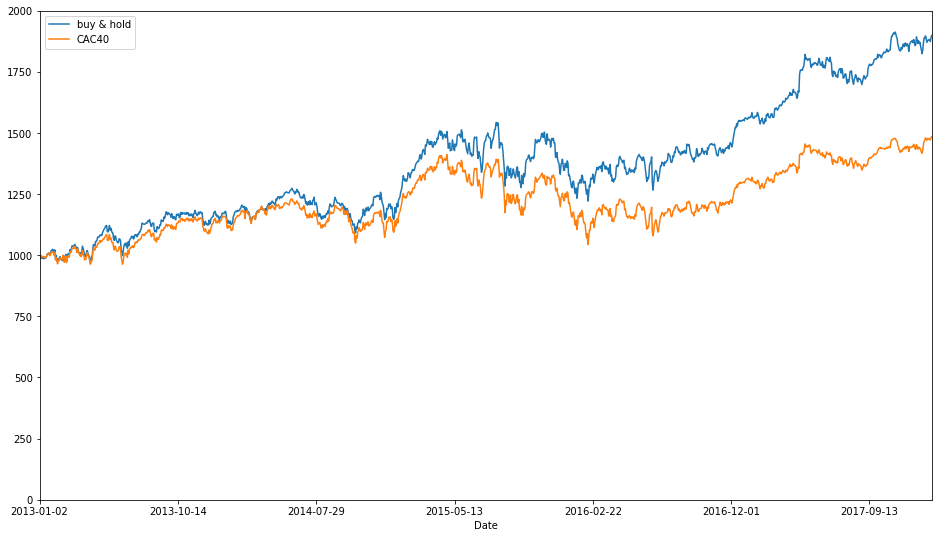

In [79]:
# plot
evo['TOTAL'].plot(label='buy & hold')
evo['Adj CloseCAC40'].plot(label='CAC40')
plt.legend()
axes = plt.gca()
axes.set_ylim([0,2000])
plt.show()


## Why does blue overperform orange ?

- **survivor bias** : I only stocks that were in the CAC40 today so all the companies that left it : EDF, Alstom, Klépierre, Gemalto, Vallourec are not taken into account and typically saw their value diminish or not grow as strongly as others.

- luck - we took the strongest companies of the CAC40, maybe we just had luck